In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import zipfile
import os


zip_file_name = '/content/drive/MyDrive/CNN/Covid19-Pneumonia-Normal Chest X-Ray Images Dataset.zip'


drive_folder = '/content/data'


with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/data')


extracted_folder = '/content/data'
for file in os.listdir(extracted_folder):
    full_path = os.path.join(extracted_folder, file)
    destination_path = os.path.join(drive_folder, file)
    os.rename(full_path, destination_path)

In [10]:
from PIL import Image


root_folder = '/content/data'
new_root_folder = '/content/reshaped_data'


class_folders = ['COVID', 'NORMAL', 'PNEUMONIA']


new_size = (128, 128)

def reshape_images(class_folder):
    folder_path = os.path.join(root_folder, class_folder)
    new_folder_path = os.path.join(new_root_folder, f'{class_folder}')

    os.makedirs(new_folder_path, exist_ok=True)


    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)


            img = Image.open(image_path)


            img_resized = img.resize(new_size)
            img_rgb = img_resized.convert('RGB')


            new_image_path = os.path.join(new_folder_path, filename)
            img_rgb.save(new_image_path)


for class_folder in class_folders:
    reshape_images(class_folder)


Checking a sample image from the dataset

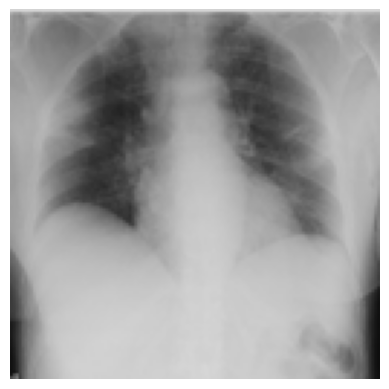

In [12]:
import matplotlib.pyplot as plt

image_path = '/content/reshaped_data/COVID/COVID_10.png'
img = Image.open(image_path)


plt.imshow(img)
plt.axis('off')
plt.show()


Splitting the data into train_data,test_data and validation_data
Creating folders for the train,test,validation data

In [13]:
import os
from sklearn.model_selection import train_test_split
import shutil


root_folder = '/content/reshaped_data'


class_folders = ['COVID', 'NORMAL', 'PNEUMONIA']


train_folder = '/content/train_data'
test_folder = '/content/test_data'
val_folder = '/content/val_data'


os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)


for class_folder in class_folders:
    class_path = os.path.join(root_folder, class_folder)


    image_filenames = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]


    train_val_filenames, test_filenames = train_test_split(image_filenames, test_size=0.2, random_state=42)
    train_filenames, val_filenames = train_test_split(train_val_filenames, test_size=0.1, random_state=42)


    train_class_folder = os.path.join(train_folder, class_folder)
    test_class_folder = os.path.join(test_folder, class_folder)
    val_class_folder = os.path.join(val_folder, class_folder)

    os.makedirs(train_class_folder, exist_ok=True)
    os.makedirs(test_class_folder, exist_ok=True)
    os.makedirs(val_class_folder, exist_ok=True)


    for filename in train_filenames:
        src_path = os.path.join(class_path, filename)
        dest_path = os.path.join(train_class_folder, filename)
        shutil.move(src_path, dest_path)

    for filename in test_filenames:
        src_path = os.path.join(class_path, filename)
        dest_path = os.path.join(test_class_folder, filename)
        shutil.move(src_path, dest_path)

    for filename in val_filenames:
        src_path = os.path.join(class_path, filename)
        dest_path = os.path.join(val_class_folder, filename)
        shutil.move(src_path, dest_path)


Create ImageDataGenerator instances for training, testing, and validation sets, with rescaling applied to pixel values for normalization.
Flow_from_directory generators are then created for the train, test, and validation sets, specifying the input folders, target image size, batch size, and categorical class mode for multi-class classification.


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)


batch_size = 25


train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical'
)
valid_generator = valid_datagen.flow_from_directory(
    val_folder,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 3762 images belonging to 3 classes.
Found 1047 images belonging to 3 classes.
Found 419 images belonging to 3 classes.


Creating a Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Creating a model
model = Sequential()

# Convolutional Layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flattening Layer
model.add(Flatten())

# Dense Layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
num_classes = 3 # num_classes is the number of classes in your classification task
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
import tensorflow as tf
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [18]:
from tensorflow.keras.callbacks import  EarlyStopping
from tensorflow.keras.optimizers import Adam


# Define the number of epochs
# epochs = 10
# epochs = 200
epochs = 150

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

optimizer = Adam(learning_rate=1e-3, beta_1=0.8)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    batch_size=batch_size,
    callbacks=[early_stopping]
)


Epoch 1/150
151/151 [==============================] - 14s 49ms/step - loss: 0.9152 - accuracy: 0.5162 - val_loss: 0.4764 - val_accuracy: 0.8640
Epoch 2/150
151/151 [==============================] - 7s 47ms/step - loss: 0.3879 - accuracy: 0.8658 - val_loss: 0.3359 - val_accuracy: 0.8759
Epoch 3/150
151/151 [==============================] - 7s 43ms/step - loss: 0.2428 - accuracy: 0.9264 - val_loss: 0.1583 - val_accuracy: 0.9547
Epoch 4/150
151/151 [==============================] - 5s 36ms/step - loss: 0.2062 - accuracy: 0.9423 - val_loss: 0.1751 - val_accuracy: 0.9379
Epoch 5/150
151/151 [==============================] - 10s 67ms/step - loss: 0.1606 - accuracy: 0.9500 - val_loss: 0.1286 - val_accuracy: 0.9594
Epoch 6/150
151/151 [==============================] - 10s 65ms/step - loss: 0.1447 - accuracy: 0.9596 - val_loss: 0.1235 - val_accuracy: 0.9690
Epoch 7/150
151/151 [==============================] - 7s 47ms/step - loss: 0.1371 - accuracy: 0.9609 - val_loss: 0.1577 - val_accura

In [19]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

42/42 [==============================] - 2s 35ms/step - loss: 0.1378 - accuracy: 0.9637
Test Loss: 0.13782274723052979, Test Accuracy: 0.963705837726593


Plotting a graph training_accuracy and validation_accuracy

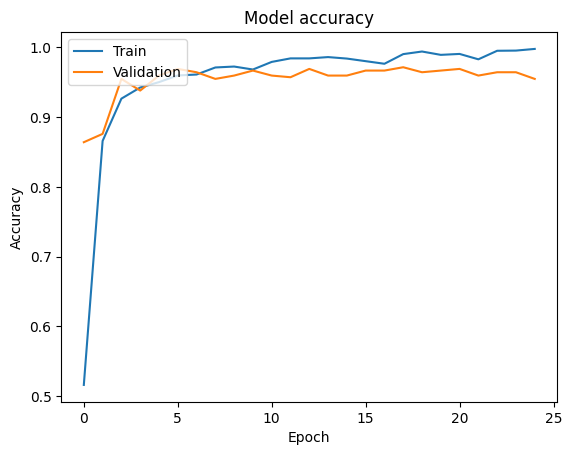

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.show()


Plotting the Model Loss

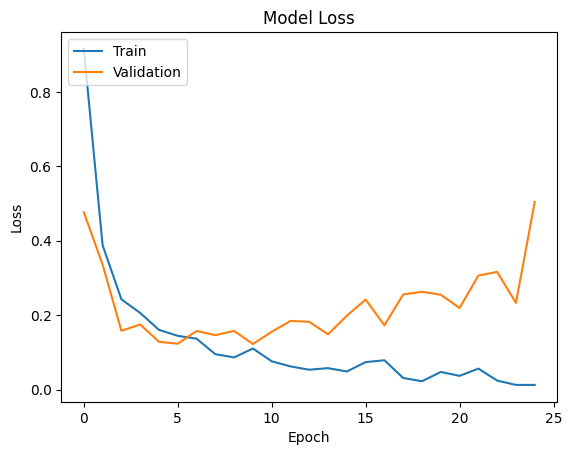

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Predicting a sample image from the test_data

In [22]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np


image_path = '/content/test_data/NORMAL/NORMAL_1009.png'


img = load_img(image_path, target_size=(128, 128))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)


predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])


class_names = ['COVID', 'NORMAL', 'PNEUMONIA']
predicted_class = class_names[predicted_class_index]

print(f'The predicted class for the image is: {predicted_class}')


1/1 [==============================] - 0s 292ms/step
The predicted class for the image is: NORMAL


Evaluating the Model's accuracy on test_data by iterating through the sub_folders

In [23]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os
import numpy as np
from sklearn.metrics import accuracy_score


root_directory = '/content/test_data'

class_names = ['COVID', 'NORMAL', 'PNEUMONIA']

true_labels = []
predicted_labels = []


for class_name in class_names:
    class_directory = os.path.join(root_directory, class_name)


    for file_name in os.listdir(class_directory):

        file_path = os.path.join(class_directory, file_name)


        img = load_img(file_path, target_size=(128, 128))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        true_label = class_names.index(class_name)
        true_labels.append(true_label)


        predictions = model.predict(img_array)
        predicted_label = np.argmax(predictions[0])
        predicted_labels.append(predicted_label)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)

print(f'Accuracy: {accuracy * 100:.2f}%')


1/1 [==============================] - 0s 18ms/step
Accuracy: 90.35%


Calculating the Performance Metrics of the Model

Precision: 0.9109
Recall: 0.9035
F1 Score: 0.9039
Confusion Matrix:


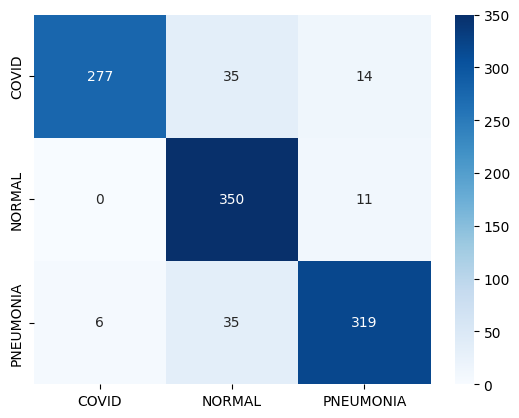

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels,predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())


print('Confusion Matrix:')



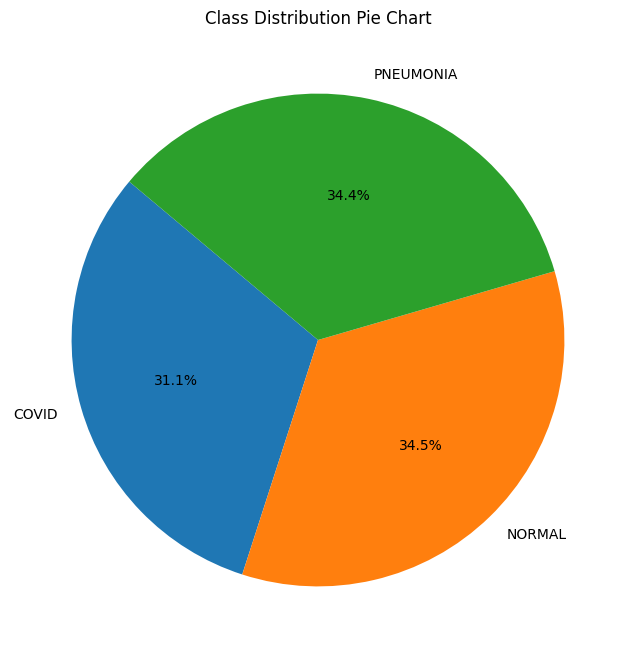

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

class_names = ['COVID', 'NORMAL', 'PNEUMONIA']


class_counts = Counter(true_labels)


plt.figure(figsize=(8, 8))
plt.pie(class_counts.values(), labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution Pie Chart')
plt.show()
